# 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [27]:
from importlib.metadata import version
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow as tf
import numpy as np
import summa
import pandas as pd
import urllib.request
import os
import re
from tqdm import tqdm
import json

from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary
아래의 코드로 데이터를 다운로드할 수 있어요.

In [3]:
file_path = "news_summary_more.csv"

if os.path.isfile(file_path):
    print("The file exists.")
else:
    print("The file does not exist.")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

The file exists.


### 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.

추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.
- text를 본문
- headlines를 요약

In [7]:
data.sample(10)

,headlines,text
77704,"Elon Musk says he's bipolar, suffers from unre...",Tesla and SpaceX CEO Elon Musk on Sunday tweet...
14787,PUBG banned 13 million players since June 2017...,"Bluehole, the company behind PlayerUnknown's B..."
55594,176 non-performing govt officers retired in pu...,As many as 176 government officers were asked ...
85585,Will I be called a Hindutva icon for wearing a...,Actress Raveena Tandon asked on Twitter if she...
60491,"Head transplant successful on corpse, Italian ...",Italian neurosurgeon Sergio Canavero claims to...
55590,Someone very famous once cheated on me: Shahid...,"Actor Shahid Kapoor, while speaking about infi..."
3335,Pleasure to watch Kuldeep Yadav bowl: Shane Warne,Former Australian spinner Shane Warne congratu...
23436,Reliance wins arbitration against government's...,An international arbitration tribunal rejected...
65142,Snapdeal's CFO Anup Vikal quits,E-commerce platform Snapdeal's Chief Financial...
14221,Guj a peace-loving state: UP CM on attacks on ...,Talking about the attacks in Gujarat on migran...


## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 2-1.중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('전체 데이터 갯수 :', len(data))

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 데이터 갯수 : 98401
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2-2 텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 데이터 전처리 및 기존 데이터 조회
file_path = "clean_text.json"

if os.path.isfile(file_path):
    #기존 데이터 조회
    with open('clean_text.json', 'r') as file:
        clean_text = json.load(file)

    with open('clean_headlines.json', 'r') as file:
        clean_headlines = json.load(file)
else:
    clean_text = []

    # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
    for s in tqdm(data['text']):
        clean_text.append(preprocess_sentence(s))

    # 전처리 후 출력
    clean_text[:5]
    
    clean_headlines = []

    # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
    for s in tqdm(data['headlines']):
        clean_headlines.append(preprocess_sentence(s, False))

    clean_headlines[:5]

    #데이터 임시 저장
    with open('clean_text.json', 'w') as file:
        json.dump(clean_text, file)

    with open('clean_headlines.json', 'w') as file:
        json.dump(clean_headlines, file)




### 2-3 훈련데이터와 테스트데이터 나누기

샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


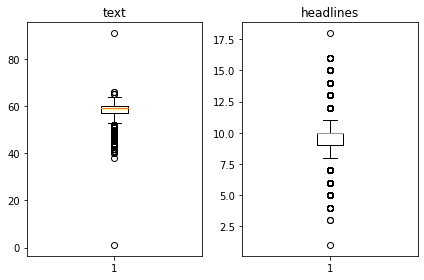

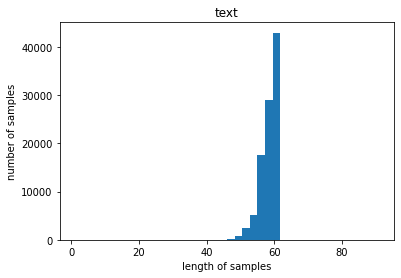

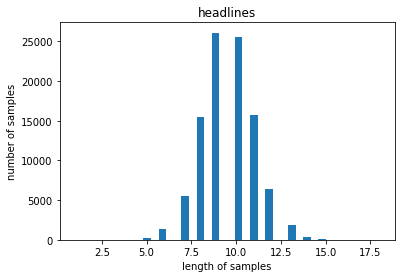

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서 부터 차례대로 그래프는
- 약과 실제 텍스트의 길이 분포
- 요약본 샘플 길이별 갯수
- 실제 텍스트 샘플 길이별 갯수

Text의 경우 최소 길이가 1, 최대 길이가 91으로 그 차이가 커요. 하지만 평균 길이는 58로 시각화 된 그래프로 봤을 때는 대체적으로는 60 내외의 길이를 가진다는 것을 확인할 수 있어요.

headlines 경우 최소 길이가 1, 최대 길이가 18, 그리고 평균 길이가 9.5로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

#### Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.

In [13]:
text_max_len = 65
headlines_max_len = 11.5

In [14]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))), cnt)

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 65 이하인 샘플의 비율: 0.9999694997966653 98357
전체 샘플 중 길이가 11.5 이하인 샘플의 비율: 0.9121492476616511 89719


### 2-4 시작 토큰과 종료 토큰 추가하기

In [18]:
print('전체 샘플수:', len(data))
data = data[
    (data['text'].apply(lambda text: len(text.split())) < text_max_len) &
    (data['headlines'].apply(lambda headlines: len(headlines.split())) < headlines_max_len)
]


전체 샘플수: 89715


In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...,sostoken Cong wins Ramgarh bypoll in Rajasthan...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."
10,UP cousins fed human excreta for friendship wi...,Two minor cousins in Uttar Pradesh's Gorakhpur...,sostoken UP cousins fed human excreta for frie...,UP cousins fed human excreta for friendship wi...


In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56812 57814 44827 ... 12803 32830 87182]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17943


In [59]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 71772
훈련 레이블의 개수 : 71772
테스트 데이터의 개수 : 17943
테스트 레이블의 개수 : 17943


### 2-6 데이터 토크나이저 (Tokenizer) text2int

In [60]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [61]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 88276
등장 빈도가 6번 이하인 희귀 단어의 수: 64431
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23845
단어 집합에서 희귀 단어의 비율: 72.98812814354977
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.8945219627236685


In [62]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 24,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [63]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3, 1957, 1700, 565, 3, 3350, 2424, 124, 550, 343, 7404, 19, 24, 4773, 31, 56, 139, 4, 521, 1, 425, 12, 2059, 1, 2266, 3972, 18, 3, 2653, 5, 16120, 27, 826, 2, 7920, 32, 1, 425, 28, 12959, 1, 139, 16, 2189, 46, 2424, 8, 29, 1143, 14, 1, 403, 6, 24, 508, 8, 29, 272, 91, 1, 147], [3, 1499, 22, 1129, 337, 7921, 390, 17610, 1129, 1530, 299, 8, 10, 11, 116, 291, 2047, 23, 423, 68, 2275, 12195, 5, 1, 2510, 2, 760, 4, 3, 575, 1169, 15, 33, 11, 760, 78, 432, 2047, 2, 808, 1670, 288, 5, 43, 2181, 813, 1, 748, 5141, 9, 24, 1792, 13, 2, 605, 3, 180, 3918, 15, 96], [1, 354, 5, 1149, 1541, 4650, 131, 4, 1, 741, 1584, 891, 5, 18462, 4001, 23846, 2525, 3105, 20, 1149, 9716, 26, 897, 24, 7686, 4, 1, 15447, 5, 12960, 14825, 1990, 1, 51, 5, 214, 13, 3143, 1, 137, 14318, 7212, 1520, 28, 432, 2, 1788, 43, 3286]]


In [64]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [65]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39591
등장 빈도가 5번 이하인 희귀 단어의 수: 28709
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10882
단어 집합에서 희귀 단어의 비율: 72.51395519183653
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.699232379623169


In [66]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 65, 498, 2129, 12, 4782, 59, 25, 463, 763, 4, 154], [1, 158, 328, 1292, 297, 924, 3, 1885, 3313, 1454], [1, 1105, 2203, 203, 4, 531, 2371, 2992, 2698], [1, 1239, 3, 4073, 12, 9, 45, 59, 728, 58, 1337], [1, 1615, 219, 6166, 212, 3, 140, 6493]]
target
decoder  [[65, 498, 2129, 12, 4782, 59, 25, 463, 763, 4, 154, 2], [158, 328, 1292, 297, 924, 3, 1885, 3313, 1454, 2], [1105, 2203, 203, 4, 531, 2371, 2992, 2698, 2], [1239, 3, 4073, 12, 9, 45, 59, 728, 58, 1337, 2], [1615, 219, 6166, 212, 3, 140, 6493, 2]]


In [67]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71772
훈련 레이블의 개수 : 71772
테스트 데이터의 개수 : 17943
테스트 레이블의 개수 : 17943


### 2-7 패딩 작업

In [70]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


TypeError: 'float' object cannot be interpreted as an integer

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.

실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요.

반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.